In [4]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

In [5]:
folders = glob.glob("../data/00_gaze_data/sub*")
folders.sort()
subjs = []
for f in folders:
    subjs.append(f[-6:])
print(len(subjs))   

#subjs = subjs[:7]
print(subjs)

40
['sub001', 'sub002', 'sub003', 'sub004', 'sub005', 'sub006', 'sub007', 'sub008', 'sub009', 'sub010', 'sub011', 'sub012', 'sub013', 'sub014', 'sub015', 'sub016', 'sub017', 'sub018', 'sub019', 'sub020', 'sub021', 'sub022', 'sub023', 'sub024', 'sub025', 'sub026', 'sub027', 'sub028', 'sub029', 'sub030', 'sub031', 'sub032', 'sub033', 'sub034', 'sub035', 'sub036', 'sub037', 'sub038', 'sub039', 'sub040']


In [6]:
# create a list of condition values (which is stored as 1/2 in the main subject memory file
memory_df = pd.read_csv('../data/01_interview_data/recall_vr_driving_e.csv')
subj_restrict_counter = 39
memory_df = memory_df.loc[:subj_restrict_counter]
replacement_mapping = {1: "count trash", 2: "free viewing"}
condition_index = [replacement_mapping.get(item, item) for item in memory_df['condition'].values]
print(condition_index)

['count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash']


In [39]:
list_of_dataframes = []

for i in range(len(subjs)): 
    read_file_name = '../data/03_fixation_billboards_recall_recognition/'  + subjs[i] +'_fixations_billboards_recall_recognition_emointegrated.csv'
    df = pd.read_csv(read_file_name, index_col = 0)
    df['subject'] = subjs[i]
    df["condition"] = condition_index[i]
    list_of_dataframes.append(df)
    
large_df = pd.concat(list_of_dataframes)

#large_df['billboard_emotionality'] = df['billboard_image_at_position_text_emotion'].str.contains('_emo').astype(float)
large_df['billboard_emotionality'] = large_df['billboard_image_at_position_text_emotion'].apply(lambda x: 'high_emo' if '_emo' in x else 'low_emo')


large_df.tail()

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality
14,15,coffee,coffee_emo,15.0,1.0,0.0,sub040,count trash,high_emo
15,17,furniture,furniture_emo,17.0,1.0,0.0,sub040,count trash,high_emo
16,18,sun_protection,sun_protection_neu,18.0,1.0,0.0,sub040,count trash,low_emo
17,19,hotel,hotel_emo,19.0,2.0,0.0,sub040,count trash,high_emo
18,20,brunch,brunch_neu,20.0,1.0,1.0,sub040,count trash,low_emo


In [40]:
large_df['fix_binarized'] = large_df['fix_bill']
#large_df.iloc[large_df['fix_binarized']>2] = 2

large_df.loc[large_df['fix_binarized'] > 1, 'fix_binarized'] = 1
#large_df.loc[large_df['fix_binarized'] > 3, 'fix_binarized'] = 3

large_df.head()

#commenting out saving
#large_df.to_csv('../data/04_statistics/csv/billboard_fixations_recall_recognition_df.csv')

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality,fix_binarized
0,1,text_driving,text_driving_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
1,2,burger,burger_neu,2.0,1.0,0.0,sub001,count trash,low_emo,1.0
2,3,buckle_up,buckle_up_neu,0.0,0.0,0.0,sub001,count trash,low_emo,0.0
3,4,hotel,hotel_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
4,5,sun_protection,sun_protection_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0


In [41]:
#by_pos_df

(0.0, 4.0)

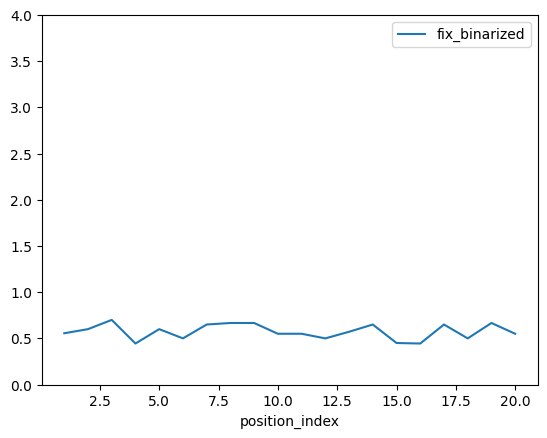

In [42]:
large_df.head()
by_pos_df = large_df[large_df['condition']=='count trash'].groupby('position_index').agg({'fix_binarized':'mean'})
by_pos_df.plot()
plt.ylim([0,4])

#by_pos_df = large_df[large_df['condition']=='free viewing'].groupby('position_index').mean()
#by_pos_df.plot()
#plt.ylim([0,4])

In [43]:
large_df.groupby('subject').agg({'fix_binarized':'sum', 'recall':'sum'})

,fix_binarized,recall
subject,,
sub001,3.0,0.0
sub002,19.0,5.0
sub003,7.0,2.0
sub004,17.0,6.0
sub005,19.0,4.0
sub006,18.0,3.0
sub007,18.0,5.0
sub008,7.0,2.0
sub009,16.0,5.0


In [44]:
by_subject_df = large_df.groupby('subject').agg({'fix_binarized':'sum', 'recall':'sum'})
#by_subject_df = by_subject_df.drop(columns = "fix_binarized")
by_subject_df['recall_rate'] = by_subject_df['recall']/20 
#by_subject_df['recognition_rate'] = by_subject_df['recognition']/20 
by_subject_df

,fix_binarized,recall,recall_rate
subject,,,
sub001,3.0,0.0,0.00
sub002,19.0,5.0,0.25
sub003,7.0,2.0,0.10
sub004,17.0,6.0,0.30
sub005,19.0,4.0,0.20
sub006,18.0,3.0,0.15
sub007,18.0,5.0,0.25
sub008,7.0,2.0,0.10
sub009,16.0,5.0,0.25


### Plot

In [45]:
large_df

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality,fix_binarized
0,1,text_driving,text_driving_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
1,2,burger,burger_neu,2.0,1.0,0.0,sub001,count trash,low_emo,1.0
2,3,buckle_up,buckle_up_neu,0.0,0.0,0.0,sub001,count trash,low_emo,0.0
3,4,hotel,hotel_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
4,5,sun_protection,sun_protection_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
...,...,...,...,...,...,...,...,...,...,...
14,15,coffee,coffee_emo,15.0,1.0,0.0,sub040,count trash,high_emo,1.0
15,17,furniture,furniture_emo,17.0,1.0,0.0,sub040,count trash,high_emo,1.0
16,18,sun_protection,sun_protection_neu,18.0,1.0,0.0,sub040,count trash,low_emo,1.0
17,19,hotel,hotel_emo,19.0,2.0,0.0,sub040,count trash,high_emo,1.0


In [46]:
large_df.condition

0     count trash
1     count trash
2     count trash
3     count trash
4     count trash
         ...     
14    count trash
15    count trash
16    count trash
17    count trash
18    count trash
Name: condition, Length: 760, dtype: object

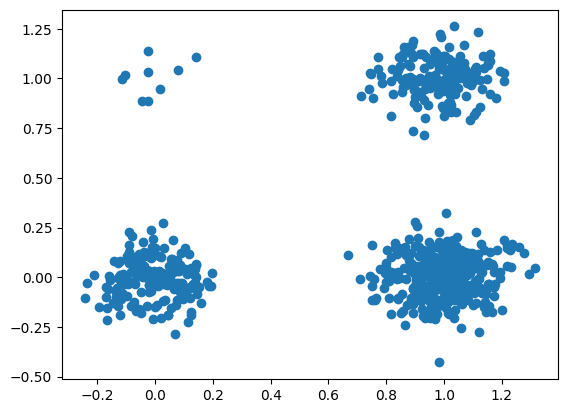

In [47]:
plt.scatter(x = jitter(large_df.fix_binarized,0), 
                y = jitter(large_df.recall,0),
                );

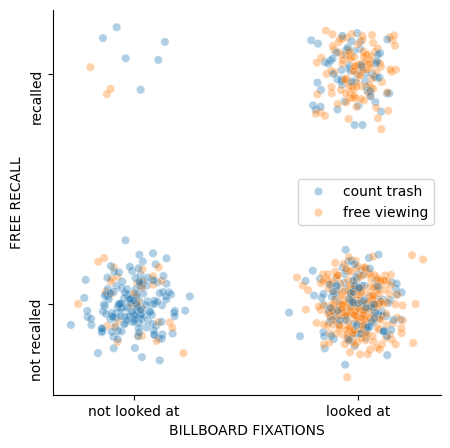

In [48]:
# list with ordered categories
fig, ax = plt.subplots(1, figsize=(5,5))

sns.scatterplot(x = jitter(large_df.fix_binarized,0), 
                y = jitter(large_df.recall,0),
                hue = large_df.condition,
                alpha=0.35,
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recalled', 'recalled'])
plt.yticks(rotation=90)
plt.ylabel('FREE RECALL');

sns.despine()

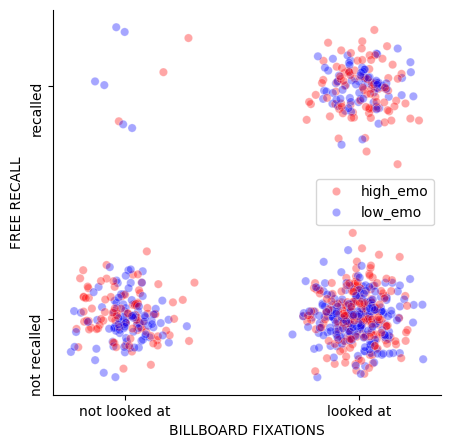

In [49]:
custom_palette = {'high_emo': 'red', 'low_emo': 'blue'}


fig, ax = plt.subplots(1, figsize=(5,5))

sns.scatterplot(x = jitter(large_df.fix_binarized,0), 
                y = jitter(large_df.recall,0),
                hue = large_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette, 
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recalled', 'recalled'])
plt.yticks(rotation=90)
plt.ylabel('FREE RECALL');

sns.despine()

### Gradient analysis

In [50]:
subjres = []

for i in range(len(subjs)):
    res = np.zeros(3)
    
    df = large_df[large_df['subject'] == subjs[i]]
    curr_sub_med_fix = df[ df['fix_bill']!=0]['fix_bill'].median()

    res[0] = df[ df['fix_bill']==0]['recall'].sum()

    interim_df = df[ df['fix_bill'] > 0 ]
    interim_df = interim_df[ interim_df['fix_bill'] < curr_sub_med_fix ]
    res[1] = interim_df['recall'].sum()    

    res[2] = df[ df['fix_bill']>curr_sub_med_fix]['recall'].sum()  # more than 2 fixations
    
    subjres.append(res)
    
subj_df = pd.DataFrame(np.asarray(subjres), columns = ['not_fixated_recalled', 'some_fixated_recalled','alot_fixated_recalled'])
subj_df['subject'] = subjs
subj_df['condition'] = condition_index

#commenting out saving
subj_df.to_csv('../data/04_statistics/csv/billboad_fixation_gradient_recall_R1.csv')

In [51]:
subj_df

,not_fixated_recalled,some_fixated_recalled,alot_fixated_recalled,subject,condition
0,0.0,0.0,0.0,sub001,count trash
1,0.0,3.0,1.0,sub002,count trash
2,0.0,1.0,1.0,sub003,count trash
3,0.0,4.0,2.0,sub004,count trash
4,0.0,2.0,2.0,sub005,count trash
5,0.0,2.0,1.0,sub006,count trash
6,0.0,0.0,5.0,sub007,count trash
7,0.0,2.0,0.0,sub008,count trash
8,2.0,0.0,3.0,sub009,count trash
9,0.0,0.0,0.0,sub010,count trash
